In [2]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [3]:
class JackCarRental(object):
    def __init__(self, max_car_num=20):
        self.max_num = max_car_num
        self.state_value = np.zeros((self.max_num + 1, self.max_num + 1))
        self.action_space = np.linspace(start=-5, stop=5, num=11, dtype=int)
        
        
        self.truncated_threshold = 1e-6
        self.request_distribution_lot1 = TruncatedPoissonDistribution(3, self.truncated_threshold)
        self.return_distribution_lot1 = TruncatedPoissonDistribution(3, self.truncated_threshold)
        self.request_distribution_lot2 = TruncatedPoissonDistribution(4, self.truncated_threshold)
        self.return_distribution_lot2 = TruncatedPoissonDistribution(2, self.truncated_threshold)

        self.p_lot1, self.r_lot1 = self.open_to_close(self.request_distribution_lot1, self.return_distribution_lot1)
        self.p_lot2, self.r_lot2 = self.open_to_close(self.request_distribution_lot2, self.return_distribution_lot2)

    def reset(self):
        pass

    def step(self, s, a):

        """Business ends"""
        car_num_lot1, car_num_lot2 = s

        """Car moving overnight"""

        move_car_num = self.move_car(s, a)
        car_num_lot1_after_move = car_num_lot1 - move_car_num
        car_num_lot2_after_move = car_num_lot2 + move_car_num

        """Business starts"""
        request_car_lot1_num = self.request_distribution_lot1.sample()
        request_car_lot2_num = self.request_distribution_lot2.sample()

        return_car_lot1_num = self.return_distribution_lot1.sample()
        return_car_lot2_num = self.return_distribution_lot2.sample()

        """Business ends"""
        car_num_lot1_new = self.update_car_num(car_num_lot1_after_move, request_car_lot1_num, return_car_lot1_num)
        car_num_lot2_new = self.update_car_num(car_num_lot2_after_move, request_car_lot2_num, return_car_lot2_num)

        prob = self.p_lot1[car_num_lot1_after_move][car_num_lot1_new] * \
            self.p_lot2[car_num_lot2_after_move][car_num_lot2_new]

        reward = self.compute_reward(move_car_num, car_num_lot1_after_move, car_num_lot2_after_move)

        next_s = [car_num_lot1_new, car_num_lot2_new]

        return next_s, reward, prob

    def compute_reward(self, moved_cars, car_num_lot1, car_num_lot2):

        # compute the cost + expected reward at lot1 + expected reward at lot2
        return -2 * abs(moved_cars) + self.r_lot1[car_num_lot1] + self.r_lot2[car_num_lot2]

    def compute_reward_modified(self, moved_cars, car_num_lot1, car_num_lot2):
        

        """ Modified the reward function based on the description in (b)"""
        penalty = -2 * (abs(moved_cars) - 1)
        additional_penalty = 0
        if car_num_lot1 > 10:
            additional_penalty -= 4
        if car_num_lot2 > 10:
            additional_penalty -= 4
            
        return -2 * penalty + self.r_lot1[car_num_lot1] + self.r_lot2[car_num_lot2] + additional_penalty

    def open_to_close(self, request_distribution, return_distribution):

        p_arr = np.zeros((26, 21))
        r_arr = np.zeros(26)

        for request_num, request_prob in request_distribution:
           
            for n in range(26):
                r_arr[n] += request_prob * 10 * min(n, request_num)

            # compute the transition function
            for return_num, return_prob in return_distribution:
                for n in range(26):
                    # compute the new n by the end of the day
                    new_n = self.update_car_num(n, request_num, return_num)
                    # update the probability incrementally
                    p_arr[n][new_n] += request_prob * return_prob

        return p_arr, r_arr

    @staticmethod
    def update_car_num(cars_num, request_cars_num, return_cars_num):

        return min(max(cars_num - request_cars_num, 0) + return_cars_num, 20)

    @staticmethod
    def move_car(state, action):

        return int(np.clip(action, a_min=-state[1], a_max=state[0]))
    
    
# Implement the truncated Poisson distribution
class TruncatedPoissonDistribution(object):
    def __init__(self, mean, threshold):
        # Check the validation of the mean and threshold
        assert isinstance(mean, int), mean > 0
        assert 0 < threshold < 1.0

        # Store the mean of the Poisson distribution
        self.mean = mean
        # Store the threshold of p(k). Only k with p(k) > threshold would be considered
        self.truncated_threshold = threshold

        # create a list to store the selected discrete values and their probabilities
        self.truncated_values, self.truncated_prob = self.truncate_poisson()

    def truncate_poisson(self):
        """ Create the truncated Poisson distribution with a finite set of ks and a normalized probabilities.
        """
        # Create original Poisson distribution
        distribution = poisson(self.mean)

        # Find the maximal k to be considered
        max_k = 0
        while distribution.pmf(max_k) > self.truncated_threshold:
            max_k += 1

        # Create the truncated value list
        value_list = list(np.linspace(start=0, stop=max_k, num=max_k+1, dtype=int))

        # Create the probability
        prob_list = [distribution.pmf(k) for k in value_list]

        # Normalize the probability for the truncated values
        prob_list = (prob_list / np.sum(prob_list)).tolist()

        return value_list, prob_list

    def sample(self):
        return np.random.choice(a=self.truncated_values, p=self.truncated_prob)

    def __iter__(self):
      
        return zip(self.truncated_values, self.truncated_prob)

In [4]:
"""use this to visualize the policy"""
def plot_policy(policy, title):
    policy = np.flip(policy, axis=0)

    car_num_lot1 = list(np.linspace(start=20, stop=0, num=21, dtype=int))
    car_num_lot2 = list(np.linspace(start=0, stop=20, num=21, dtype=int))

    fig, ax = plt.subplots()
    im = ax.imshow(policy, cmap="RdGy")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(car_num_lot2)), labels=car_num_lot2)
    ax.set_yticks(np.arange(len(car_num_lot1)), labels=car_num_lot1)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(car_num_lot1)):
        for j in range(len(car_num_lot2)):
            text = ax.text(j, i, policy[i, j],
                           ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

## Q6 - (a): Implement the policy iteration algorithm and generate the Figure 4.2


In [5]:
def compute_expected_return(state, action, env, gamma, state_value):

    # compute the number of car to move
    car_num_to_move = env.move_car(state, action)

    # compute the state after moving
    state_after_move = [state[0] - car_num_to_move, state[1] + car_num_to_move]

    new_v = 0
    for n_1 in range(21):
        for n_2 in range(21):
     
            prob = env.p_lot1[state_after_move[0]][n_1] * env.p_lot2[state_after_move[1]][n_2]

          
            reward = env.compute_reward(moved_cars=car_num_to_move,
                                        car_num_lot1=state_after_move[0],
                                        car_num_lot2=state_after_move[1])

           
            """ incrementally compute the new_v for the state-action pair (i.e., the expected return of (s, a))"""
            new_v += prob * (reward + gamma * state_value[n_1, n_2])

    return new_v

In [6]:
# Implement the policy evaluation
def policy_evaluation(state_value, policy, env, threshold, gamma):
    # iteration counter
    iter_counter = 0

    # check termination
    while True:
        # iteration counter
        iter_counter += 1

        # assume the current iteration should be terminated
        is_terminal = True

        # create a numpy array to store the new state value
        new_state_value = np.zeros_like(state_value)

        # loop all valid states
        for i in range(21):
            for j in range(21):
                # state (e.g. [i, j])
                old_v = state_value[i,j]   # store the old V value
                # get the action from the policy
                action = policy[i, j]
                # compute the expected return
                new_v = compute_expected_return(np.array([i,j]), action, env, gamma, state_value)
                # compute the error for this state
                # note that: is_terminal is True if and only if all states has value estimation error < the threshold
                if abs(old_v - new_v) > threshold:
                    is_terminal = False
                # store the updated state value
                new_state_value[i, j] = new_v
        # update the state value table
        state_value = new_state_value.copy()

        # check the termination
        if is_terminal:
            break

    return state_value

In [7]:
# Implement the policy improvement
def policy_improvement(state_value, policy, env, gamma):
    # assume the policy is already stable
    is_stable = True
    # loop the state space
    for i in range(21):
        for j in range(21):
  
            # state
            old_a = policy[i,j]
            # obtain the old action
            # compute a new greedy action
            v_greedy = []
            for a in env.action_space:                
                v_greedy.append(compute_expected_return(np.array([i,j]), a, env, gamma, state_value))   
            new_a = np.argmax(v_greedy) -5 # bias removed
            # check if the policy is stable at state [i, j]
            if old_a != new_a:
                is_stable = False
        
            # update the policy
            policy[i, j] = new_a
    return policy, is_stable

In [8]:
def run_policy_iteration(env, threshold, gamma):
    # initialize the policy
    policy = np.zeros((21, 21), dtype=int)

    # initialize the state value
    state_value = np.zeros((21, 21))

    # run policy iteration
    policy_iter_counter = 0
    
    # save the policies in the iteration
    results_list = []

    # start policy iteration
    while True:
        # print info
        print(f"======================================")
        print(f"==   Policy iteration = {policy_iter_counter}")
        print(f"======================================")
        
        # policy evaluation
        print(f"Iter {policy_iter_counter}: Policy evaluation starts.")
        state_value = policy_evaluation(state_value, policy, env, threshold, gamma)
        print(f"Iter {policy_iter_counter}: Policy evaluation ends.")

        # policy improvement
        print(f"Iter {policy_iter_counter}: Policy improvement starts.")
        policy, is_stable = policy_improvement(state_value, policy, env, gamma)
        print(f"Iter {policy_iter_counter}: Policy improvement ends.")
        
        # save to the list
        results_list.append({"state_value": state_value.copy(),
                             "policy": policy.copy(),
                             "title": f"Iteration = {policy_iter_counter}"})

        if is_stable:
            break
        else:
            policy_iter_counter += 1
                
    print("======================")
    print("Policy iteration ends.")
            
    return results_list

In [9]:

# run the policy iteration
env = JackCarRental()
env.reset()

# set the threshold for policy evaluation
threshold = 1e-3

# set the gamma
gamma = 0.9

# run the policy iteration
results_list = run_policy_iteration(env, threshold, gamma)

==   Policy iteration = 0
Iter 0: Policy evaluation starts.
Iter 0: Policy evaluation ends.
Iter 0: Policy improvement starts.
Iter 0: Policy improvement ends.
==   Policy iteration = 1
Iter 1: Policy evaluation starts.
Iter 1: Policy evaluation ends.
Iter 1: Policy improvement starts.
Iter 1: Policy improvement ends.
==   Policy iteration = 2
Iter 2: Policy evaluation starts.
Iter 2: Policy evaluation ends.
Iter 2: Policy improvement starts.
Iter 2: Policy improvement ends.
==   Policy iteration = 3
Iter 3: Policy evaluation starts.
Iter 3: Policy evaluation ends.
Iter 3: Policy improvement starts.
Iter 3: Policy improvement ends.
==   Policy iteration = 4
Iter 4: Policy evaluation starts.
Iter 4: Policy evaluation ends.
Iter 4: Policy improvement starts.
Iter 4: Policy improvement ends.
Policy iteration ends.


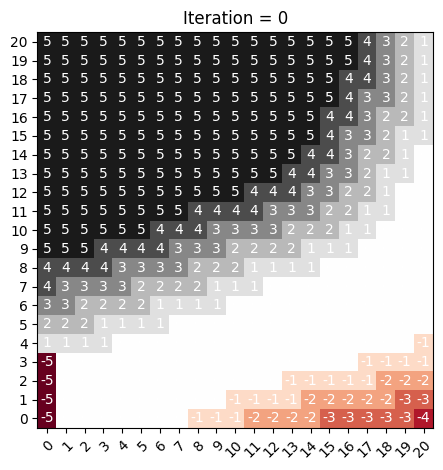

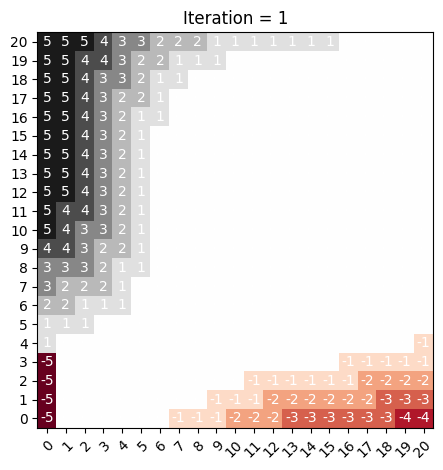

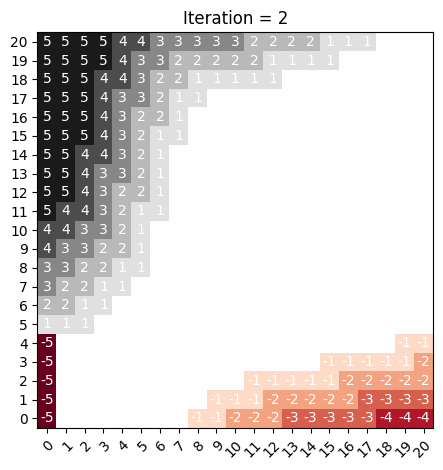

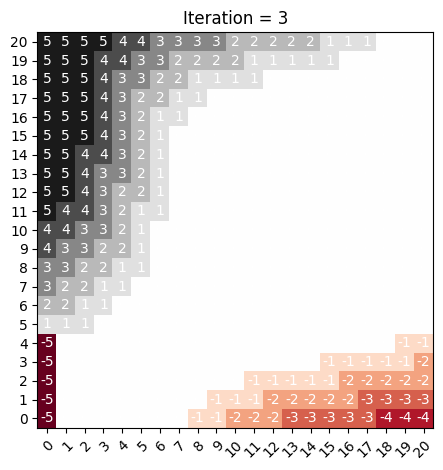

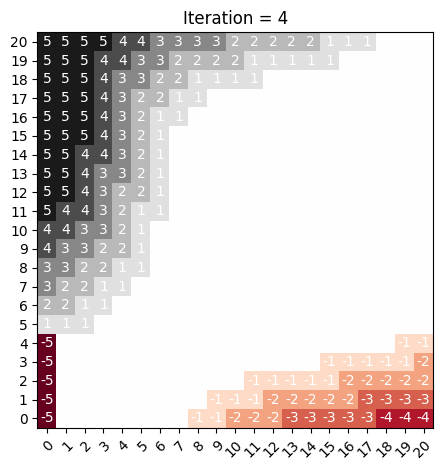

In [10]:

# plot the final policy
for res in results_list:
    policy = res['policy']
    title = res['title']
    plot_policy(policy, title)

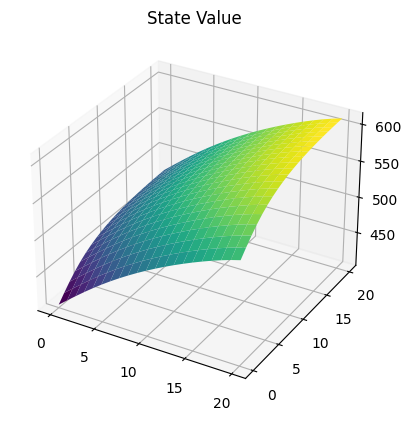

In [11]:

#Plot the value function
def plot_optimal_values(state_value):
    x = np.linspace(0, 20, 21)
    y = np.linspace(0, 20, 21)

    X, Y = np.meshgrid(x, y)
    Z = state_value
    
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('State Value')
    
state_value = results_list[0]['state_value']
plot_optimal_values(state_value)

## Q6 - (b): Apply the implemented policy iteration on the modified Jack's car rental problem

In [20]:
def compute_expected_return(state, action, env, gamma, state_value):

    car_num_to_move = env.move_car(state, action)

    state_after_move = [state[0] - car_num_to_move, state[1] + car_num_to_move]


    new_v = 0
    for n_1 in range(21):
        for n_2 in range(21):
          
            prob = env.p_lot1[state_after_move[0]][n_1] * env.p_lot2[state_after_move[1]][n_2]

           
            reward = env.compute_reward_modified(moved_cars=car_num_to_move,
                                                 car_num_lot1=state_after_move[0],
                                                 car_num_lot2=state_after_move[1])


            new_v += prob * (reward + gamma * state_value[n_1, n_2])
    return new_v

In [21]:
# Implement the policy evaluation
def policy_evaluation(state_value, policy, env, threshold, gamma):
    # iteration counter
    iter_counter = 0

    # check termination
    while True:
        # iteration counter
        iter_counter += 1

        # assume the current iteration should be terminated
        is_terminal = True

        # create a numpy array to store the new state value
        new_state_value = np.zeros_like(state_value)

        # loop all valid states
        for i in range(21):
            for j in range(21):

                # state (e.g. [i, j])
                old_v = state_value[i,j]   # store the old V value
                # get the action from the policy
                action = policy[i, j]
                # compute the expected return
                new_v = compute_expected_return(np.array([i,j]), action, env, gamma, state_value)
                if abs(old_v - new_v) > threshold:
                    is_terminal = False

                # store the updated state value
                new_state_value[i, j] = new_v
        # update the state value table
        state_value = new_state_value.copy()

        # check the termination
        if is_terminal:
            break

    return state_value

In [22]:
# Implement the policy improvement
def policy_improvement(state_value, policy, env, gamma):
    # assume the policy is already stable
    is_stable = True
    # loop the state space
    for i in range(21):
        for j in range(21):
    
            # state
            old_a = policy[i,j]
            # obtain the old action
            # compute a new greedy action
            v_greedy = []
            for a in env.action_space:                
                v_greedy.append(compute_expected_return(np.array([i,j]), a, env, gamma, state_value))   
            new_a = np.argmax(v_greedy) -5 # bias removed
            # check if the policy is stable at state [i, j]
            if old_a != new_a:
                is_stable = False

            # update the policy
            policy[i, j] = new_a
    return policy, is_stable

In [23]:

def run_policy_iteration(env, threshold, gamma):
    # initialize the policy
    policy = np.zeros((21, 21), dtype=int)

    # initialize the state value
    state_value = np.zeros((21, 21))

    # run policy iteration
    policy_iter_counter = 0
    
    # save the policies in the iteration
    results_list = []

    # start policy iteration
    while True:
        # print info
        print(f"======================================")
        print(f"==   Policy iteration = {policy_iter_counter}")
        print(f"======================================")
        
        # policy evaluation
        print(f"Iter {policy_iter_counter}: Policy evaluation starts.")
        state_value = policy_evaluation(state_value, policy, env, threshold, gamma)
        print(f"Iter {policy_iter_counter}: Policy evaluation ends.")

        # policy improvement
        print(f"Iter {policy_iter_counter}: Policy improvement starts.")
        policy, is_stable = policy_improvement(state_value, policy, env, gamma)
        print(f"Iter {policy_iter_counter}: Policy improvement ends.")
        
        # save to the list
        results_list.append({"state_value": state_value.copy(),
                             "policy": policy.copy(),
                             "title": f"Iteration = {policy_iter_counter}"})

        if is_stable:
            break
        else:
            policy_iter_counter += 1
                
    print("======================")
    print("Policy iteration ends.")
            
    return results_list

In [24]:

# run the policy iteration
env = JackCarRental()
env.reset()

# set the threshold for policy evaluation
threshold = 1e-3

# set the gamma
gamma = 0.9

# run the policy iteration
results_list = run_policy_iteration(env, threshold, gamma)

==   Policy iteration = 0
Iter 0: Policy evaluation starts.
Iter 0: Policy evaluation ends.
Iter 0: Policy improvement starts.
Iter 0: Policy improvement ends.
==   Policy iteration = 1
Iter 1: Policy evaluation starts.
Iter 1: Policy evaluation ends.
Iter 1: Policy improvement starts.
Iter 1: Policy improvement ends.
==   Policy iteration = 2
Iter 2: Policy evaluation starts.
Iter 2: Policy evaluation ends.
Iter 2: Policy improvement starts.
Iter 2: Policy improvement ends.
==   Policy iteration = 3
Iter 3: Policy evaluation starts.
Iter 3: Policy evaluation ends.
Iter 3: Policy improvement starts.
Iter 3: Policy improvement ends.
==   Policy iteration = 4
Iter 4: Policy evaluation starts.
Iter 4: Policy evaluation ends.
Iter 4: Policy improvement starts.
Iter 4: Policy improvement ends.
Policy iteration ends.


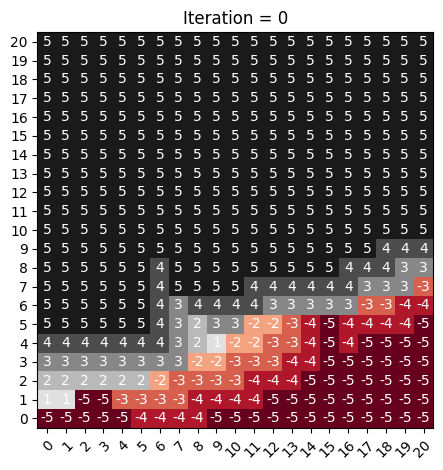

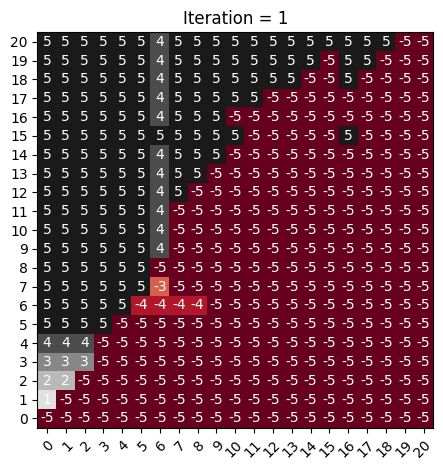

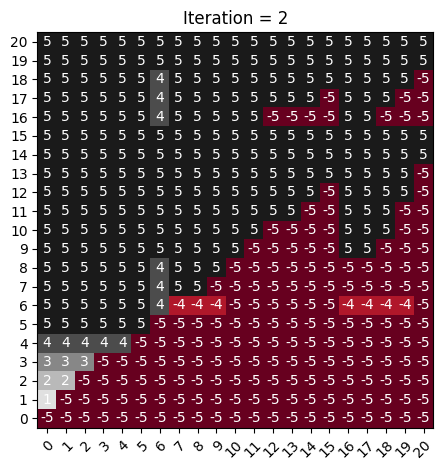

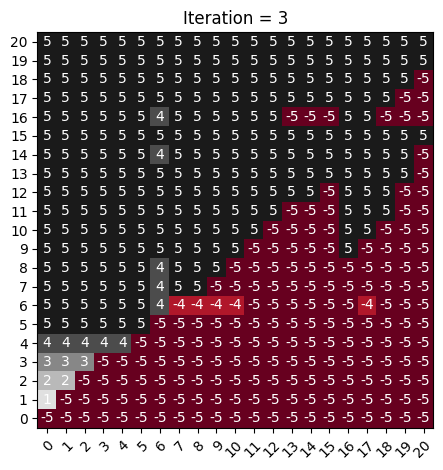

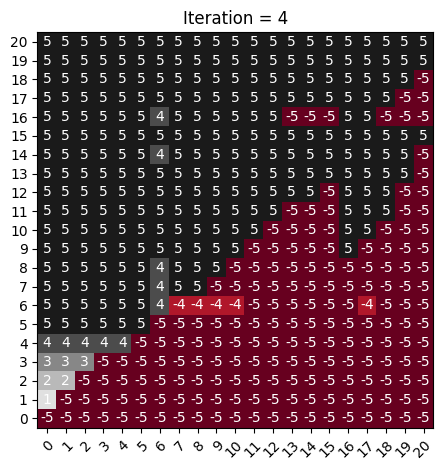

In [25]:

# plot the final policy
for res in results_list:
    policy = res['policy']
    title = res['title']
    plot_policy(policy, title)

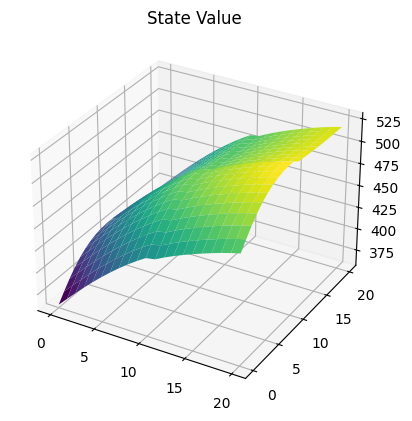

In [26]:

# Plot the value function
def plot_optimal_values(state_value):
    x = np.linspace(0, 20, 21)
    y = np.linspace(0, 20, 21)

    X, Y = np.meshgrid(x, y)
    Z = state_value
    
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('State Value')
    
state_value = results_list[0]['state_value']
plot_optimal_values(state_value)